## Importing the libraries


In [1]:
import math
import random
import scipy.stats as stats
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import requests
from io import BytesIO
import forceatlas2
warnings.filterwarnings("ignore")

## Fetching the Network

In [2]:
url = "https://raw.githubusercontent.com/Arunn1011/Social-Graphs-and-Interactions-Exercises/refs/heads/main/Week%205/artists_graph_with_stats.gexf"

# Fetch file from GitHub
response = requests.get(url)
response.raise_for_status()  

# Load into NetworkX
G = nx.read_gexf(BytesIO(response.content))
print(f"Loaded remote graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Loaded remote graph: 484 nodes, 7328 edges


## Extracting the undirected giant connected component

The original artists graph is directed because Wikipedia links have a direction. For the structural analysis in this assignment, an undirected representation is more appropriate. This section converts the graph to an undirected version and extracts the **giant connected component (GCC)**. All subsequent measurements and visualizations are based on this GCC, which avoids distortions from very small isolated components.


In [3]:
# Convert to undirected graph
G_ud = G.to_undirected()

# Optionally remove self-loops for cleaner structural measures
G_ud.remove_edges_from(nx.selfloop_edges(G_ud))

# Extract giant connected component (GCC)
if nx.is_connected(G_ud):
    G_gcc = G_ud.copy()
else:
    largest_cc = max(nx.connected_components(G_ud), key=len)
    G_gcc = G_ud.subgraph(largest_cc).copy()

n_gcc = G_gcc.number_of_nodes()
m_gcc = G_gcc.number_of_edges()
avg_deg_gcc = 2 * m_gcc / n_gcc

print(f"GCC (undirected, loop-free): {n_gcc} nodes, {m_gcc} edges")
print(f"Average degree in GCC: {avg_deg_gcc:.2f}")


GCC (undirected, loop-free): 484 nodes, 6023 edges
Average degree in GCC: 24.89


The undirected giant connected component (GCC) of the rock artists network contains **484 nodes** and **6023 edges**, corresponding to an average degree of approximately **24.9**. This indicates a relatively dense interaction pattern among artists, compared to many sparse real-world networks.

## Basic structural properties and degree distribution



To understand how connectivity is distributed across artists, the degree distribution is examined. A heavy-tailed degree distribution would indicate the presence of a small number of highly connected hubs and many sparsely connected nodes, which is typical for information and citation-like networks.


Minimum degree: 1
Median degree:  20.0
Maximum degree: 127


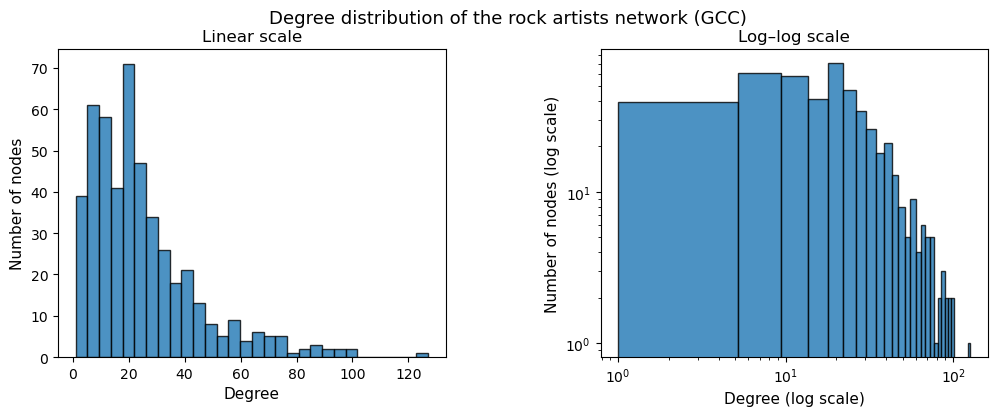

In [4]:
# Compute degrees in the GCC
degrees = dict(G_gcc.degree())
deg_values = np.array(list(degrees.values()))

print(f"Minimum degree: {deg_values.min()}")
print(f"Median degree:  {np.median(deg_values):.1f}")
print(f"Maximum degree: {deg_values.max()}")

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(12, 4),
    gridspec_kw={"wspace": 0.4}
)

fig.suptitle(
    "Degree distribution of the rock artists network (GCC)",
    fontsize=13
)

# Linear-scale degree histogram
ax1.hist(deg_values, bins=30, alpha=0.8, edgecolor="black")
ax1.set_xlabel("Degree", fontsize=11)
ax1.set_ylabel("Number of nodes", fontsize=11)
ax1.set_title("Linear scale", fontsize=12)

# Log–log view to highlight the tail
ax2.hist(deg_values, bins=30, alpha=0.8, edgecolor="black", log=True)
ax2.set_xscale("log")
ax2.set_xlabel("Degree (log scale)", fontsize=11)
ax2.set_ylabel("Number of nodes (log scale)", fontsize=11)
ax2.set_title("Log–log scale", fontsize=12)

# plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


The degree statistics show that the GCC is fairly heterogeneous: degrees range from **1** to **127**, with a median of **20**. Most artists therefore have a moderate number of connections, but a small subset are connected to an exceptionally large number of others. In the linear-scale histogram, the bulk of nodes lie between roughly 5 and 30 neighbors, while the tail extends toward much higher degrees. The log–log view emphasizes this long right tail, consistent with a **heavy-tailed degree distribution** rather than a narrow, bell-shaped one. This pattern indicates a **core–periphery structure**: a few highly connected hub artists occupy the structural core of the network and provide many of the connections, whereas the majority of artists reside in the periphery with substantially fewer links.


## Centrality: structurally important artists

To identify which artists occupy key positions in the network, two standard centrality measures are considered:

- **Degree centrality**: counts how many neighbors an artist has. This is a local measure of popularity or visibility.
- **Betweenness centrality**: counts how often an artist lies on shortest paths between other artists. This is a global measure of how important a node is for connecting different parts of the network.

The combination of these two measures makes it possible to distinguish between highly connected local hubs and artists that act as bridges between otherwise weakly connected regions of the network.


In [5]:
# Degree centrality 
deg_centrality = nx.degree_centrality(G_gcc)

# Betweenness centrality
bet_centrality = nx.betweenness_centrality(G_gcc, normalized=True)

# Combine into a DataFrame for inspection
cent_df = pd.DataFrame({
    "degree": pd.Series(degrees),
    "degree_centrality": pd.Series(deg_centrality),
    "betweenness_centrality": pd.Series(bet_centrality),
})

# Top 10 artists by degree
top_degree = cent_df.sort_values("degree", ascending=False).head(10)

# Top 10 artists by betweenness
top_betweenness = cent_df.sort_values("betweenness_centrality", ascending=False).head(10)

print("Top 10 artists by degree:")
display(top_degree)

print("Top 10 artists by betweenness centrality:")
display(top_betweenness)


Top 10 artists by degree:


,degree,degree_centrality,betweenness_centrality
Led Zeppelin,127,0.262940,0.046281
Bob Dylan,100,0.207039,0.037563
Queen (band),100,0.207039,0.030879
Metallica,96,0.198758,0.015157
Deep Purple,96,0.198758,0.029351
Black Sabbath,91,0.188406,0.014976
David Bowie,91,0.188406,0.022917
Alice in Chains,89,0.184265,0.021293
Jimi Hendrix,88,0.182195,0.026604
Guns N' Roses,88,0.182195,0.020896


Top 10 artists by betweenness centrality:


,degree,degree_centrality,betweenness_centrality
Led Zeppelin,127,0.262940,0.046281
Bob Dylan,100,0.207039,0.037563
Queen (band),100,0.207039,0.030879
Deep Purple,96,0.198758,0.029351
Jimi Hendrix,88,0.182195,0.026604
Elvis Presley,73,0.151139,0.023658
David Bowie,91,0.188406,0.022917
U2,81,0.167702,0.022557
Alice in Chains,89,0.184265,0.021293
Guns N' Roses,88,0.182195,0.020896


Both rankings are dominated by canonical rock artists. The degree ranking is led by **Led Zeppelin**, **Bob Dylan**, **Queen (band)**, **Metallica**, **Deep Purple**, **Black Sabbath**, and **David Bowie**, all of which have very large local neighborhoods. The betweenness ranking overlaps with this set but also includes artists such as **Elvis Presley** and **U2**, which have slightly lower degree but appear on many shortest paths. These artists therefore play an important **connector role** across stylistic or temporal boundaries, whereas some high-degree artists (for example Metallica or Black Sabbath) are more characteristic of large local hubs whose links are concentrated within dense regions of the network.


### Visualization of centrality structure

To illustrate how centrality is distributed across the network, a ForceAtlas2 layout of the GCC is computed. Node size is proportional to degree, and node color encodes betweenness centrality. This visualization highlights both highly connected hubs and nodes that control many shortest paths through the network.


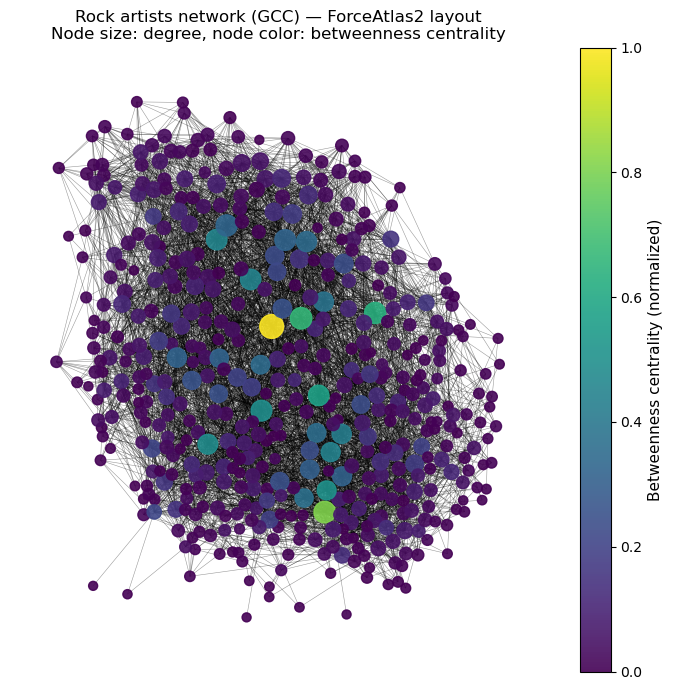

In [6]:
# Ensure compatibility for to_numpy_matrix
if not hasattr(nx, "to_numpy_matrix"):
    def _to_numpy_matrix(G, nodelist=None, dtype=float, weight="weight", nonedge=0.0):
        arr = nx.to_numpy_array(G, nodelist=nodelist, dtype=dtype, weight=weight, nonedge=nonedge)
        try:
            return np.matrix(arr)
        except Exception:
            return arr
    nx.to_numpy_matrix = _to_numpy_matrix

# Prepare data for visualization
deg_array = np.array([degrees[n] for n in G_gcc.nodes()])
bet_array = np.array([bet_centrality[n] for n in G_gcc.nodes()])

# Node sizes (scaled degree)
node_sizes = 40 + 2.0 * deg_array  # base size + scaled degree

# Node colors (betweenness, normalized to [0,1])
if bet_array.max() > 0:
    bet_norm = (bet_array - bet_array.min()) / (bet_array.max() - bet_array.min())
else:
    bet_norm = bet_array

# ForceAtlas2 layout (ForceAtlas2 library)
init_pos = {n: (np.random.rand(), np.random.rand()) for n in G_gcc.nodes()}
pos = forceatlas2.forceatlas2_networkx_layout(
    G_gcc,
    pos=init_pos,
    niter=1000
)

# Plot
fig, ax = plt.subplots(figsize=(7, 7))
nodes = nx.draw_networkx_nodes(
    G_gcc,
    pos,
    node_size=node_sizes,
    node_color=bet_norm,
    cmap=plt.cm.viridis,
    alpha=0.9,
    ax=ax,
)
nx.draw_networkx_edges(G_gcc, pos, width=0.4, alpha=0.4, ax=ax)

cbar = plt.colorbar(nodes, ax=ax)
cbar.set_label("Betweenness centrality (normalized)", fontsize=11)

ax.set_title(
    "Rock artists network (GCC) — ForceAtlas2 layout\n"
    "Node size: degree, node color: betweenness centrality",
    fontsize=12
)
ax.set_axis_off()
plt.tight_layout()
plt.show()


The ForceAtlas2 layout confirms the centrality patterns observed from the numerical measures. A small number of nodes appear both **large** and **bright**, indicating simultaneously high degree and high betweenness centrality. These artists form a dense core through which a large fraction of shortest paths pass. Surrounding this core, many smaller and darker nodes form loosely defined clusters, likely corresponding to subgenres or specific scenes that connect to the rest of the network primarily through the central hubs. Peripheral nodes with few connections tend to lie near the boundary of the layout, emphasizing their structurally marginal position.


##  Relationship between degree and betweenness centrality

Both degree and betweenness centrality identify important artists, but they capture different aspects of importance. To investigate how these measures relate, the two centralities are compared on a node-by-node basis.


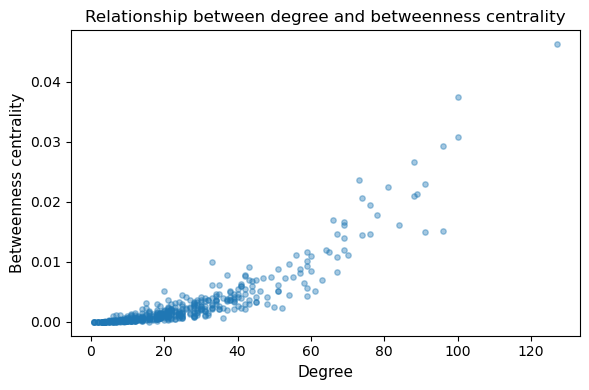

In [7]:
# Scatter plot: degree vs betweenness centrality
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(
    cent_df["degree"],
    cent_df["betweenness_centrality"],
    alpha=0.4,
    s=15,
)

ax.set_xlabel("Degree", fontsize=11)
ax.set_ylabel("Betweenness centrality", fontsize=11)
ax.set_title("Relationship between degree and betweenness centrality", fontsize=12)
plt.tight_layout()
plt.show()


The relationship between degree and betweenness centrality is clearly positive: betweenness values increase systematically with degree, and the very highest betweenness scores are attained by the most highly connected artists. This confirms that hubs tend to act as important conduits for shortest paths. At the same time, the scatter is not perfectly tight, particularly at intermediate degrees, where nodes with similar degree can display noticeably different betweenness. This variation reflects different structural roles at comparable connectivity levels, for example, some artists with medium degree connect otherwise weakly linked regions and therefore achieve higher betweenness, while others with similar degree are embedded more locally within a single dense cluster.


## Assortativity and relation to article length

Centrality focuses on individual nodes, while assortativity captures how **similar or dissimilar nodes tend to connect**. Here, degree assortativity is examined to see whether highly connected artists tend to link to other highly connected artists. In addition, the relationship between structural importance (degree) and the external attribute `length_of_content` (Wikipedia article length) is studied to check whether more connected artists also tend to have longer articles.


Degree assortativity coefficient: 0.008
Rows with article length information: 484
Pearson correlation (degree vs. article length):  0.734
Spearman correlation (degree vs. article length): 0.718


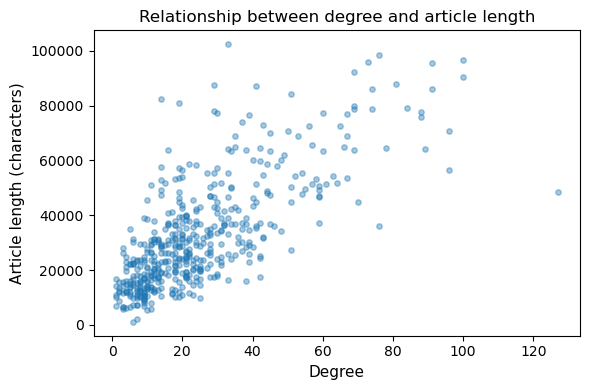

In [8]:
# Degree assortativity
deg_assort = nx.degree_assortativity_coefficient(G_gcc)
print(f"Degree assortativity coefficient: {deg_assort:.3f}")

# Degree vs. article length correlation
length_attr = nx.get_node_attributes(G_gcc, "length_of_content")

# Build dataframe for nodes where the attribute is available
rows = []
for n in G_gcc.nodes():
    if n in length_attr:
        rows.append({
            "artist": n,
            "degree": degrees[n],
            "length_of_content": length_attr[n],
        })

len_df = pd.DataFrame(rows)

print(f"Rows with article length information: {len(len_df)}")

pearson_corr = len_df["degree"].corr(len_df["length_of_content"], method="pearson")
spearman_corr = len_df["degree"].corr(len_df["length_of_content"], method="spearman")

print(f"Pearson correlation (degree vs. article length):  {pearson_corr:.3f}")
print(f"Spearman correlation (degree vs. article length): {spearman_corr:.3f}")

# scatter plot of degree vs. article length
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(len_df["degree"], len_df["length_of_content"], alpha=0.4, s=15)
ax.set_xlabel("Degree", fontsize=11)
ax.set_ylabel("Article length (characters)", fontsize=11)
ax.set_title("Relationship between degree and article length", fontsize=12)
plt.tight_layout()
plt.show()


The degree assortativity coefficient is approximately **0.008**, which is effectively neutral. This indicates that connections between artists are not strongly structured by degree: highly connected artists link to both high- and low-degree artists without a clear preference. In contrast, the correlations between degree and article length are strongly positive (Pearson ≈ **0.73**, Spearman ≈ **0.72**), and the scatter plot shows a clear upward trend. Artists with higher degree tend to have substantially longer Wikipedia pages, suggesting that structural prominence in the network is closely aligned with how extensively each artist is documented.


## Network backbone: Weighted Network 1 (betweenness-based disparity filter)

The full GCC is dense and visually cluttered, which makes it difficult to see large-scale structure. To extract a clearer structural “skeleton”, a backbone is constructed using the **disparity filter** introduced by Serrano et al. (PNAS 2009). 

First, each edge is assigned a weight proportional to its **edge betweenness centrality** (fraction of shortest paths that use the edge), rescaled to the interval \([1, 100]\). The disparity filter then tests, for each node, whether the weight of an incident edge is significantly larger than expected under a random allocation of weights. An undirected edge is kept in the backbone if it is significant for at least one of its endpoints. This emphasizes edges that are important for connecting different parts of the network.


In [9]:
# Helper: rescale values to [a, b]
def minmax_scale(vals, a=1.0, b=100.0):
    arr = np.asarray(list(vals), dtype=float)
    vmin, vmax = arr.min(), arr.max()
    if np.isclose(vmin, vmax):
        return np.full_like(arr, (a + b) / 2.0)
    return (arr - vmin) / (vmax - vmin) * (b - a) + a

# Edge betweenness centrality and weighted network W1
ebc = nx.edge_betweenness_centrality(G_gcc, normalized=True)
scaled_weights = minmax_scale(ebc.values(), a=1.0, b=100.0)

G_w1 = G_gcc.copy()
for (edge, w) in zip(ebc.keys(), scaled_weights):
    u, v = edge
    G_w1[u][v]["weight"] = float(w)

print("[W1] Weighted network constructed from edge betweenness.")


[W1] Weighted network constructed from edge betweenness.


In [10]:
# Disparity filter implementation (undirected version)
def disparity_backbone(Gw, alpha=0.20, mode="or"):
    """
    Undirected disparity filter backbone.
    Gw: weighted undirected graph with edge attribute 'weight'.
    alpha: significance level.
    mode: 'or' keeps edge if significant at either endpoint; 'and' requires both.
    """
    assert not Gw.is_directed()
    B = nx.Graph()
    B.add_nodes_from(Gw.nodes(data=True))

    # Degree and node strength
    deg = dict(Gw.degree())
    strength = {n: 0.0 for n in Gw.nodes()}
    for u, v, d in Gw.edges(data=True):
        w = float(d.get("weight", 1.0))
        strength[u] += w
        strength[v] += w

    def significant(p, k):
        if k <= 1:
            return True
        # Tail probability (Serrano et al. 2009)
        return (1.0 - p) ** (k - 1) < alpha

    for u, v, d in Gw.edges(data=True):
        w = float(d.get("weight", 1.0))
        pu = w / strength[u] if strength[u] > 0 else 0.0
        pv = w / strength[v] if strength[v] > 0 else 0.0
        keep_u = significant(pu, deg[u])
        keep_v = significant(pv, deg[v])
        keep = (keep_u or keep_v) if mode == "or" else (keep_u and keep_v)
        if keep:
            B.add_edge(u, v, **d)

    return B

# Build backbone B1 from W1
alpha_w1 = 0.20
B1 = disparity_backbone(G_w1, alpha=alpha_w1, mode="or")

edges_full = G_gcc.number_of_edges()
edges_b1 = B1.number_of_edges()
frac_kept_b1 = edges_b1 / edges_full

components_b1 = nx.number_connected_components(B1)
print(f"[B1] Backbone edges: {edges_b1} / {edges_full} ({frac_kept_b1:.1%} kept)")
print(f"[B1] Number of connected components: {components_b1}")


[B1] Backbone edges: 1120 / 6023 (18.6% kept)
[B1] Number of connected components: 3


[B1] Backbone GCC for plotting: 482 nodes, 1120 edges


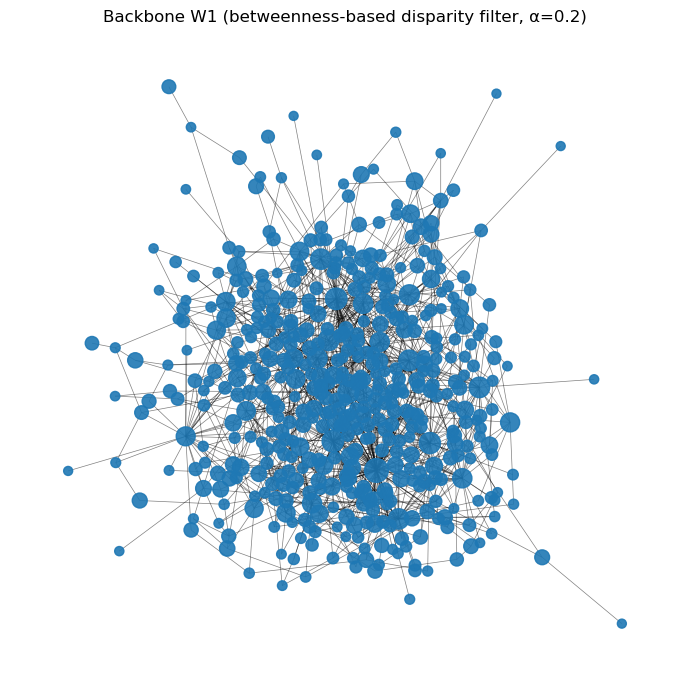

In [11]:
# Visualization of the W1 backbone (GCC only)

# Work on a copy for plotting and drop isolates to simplify the layout
H = B1.copy()
isolates = list(nx.isolates(H))
H.remove_nodes_from(isolates)

# Keep only the largest component of the backbone for visualization
if H.number_of_nodes() > 0:
    gcc_nodes_b1 = max(nx.connected_components(H), key=len)
    H_gcc = H.subgraph(gcc_nodes_b1).copy()
else:
    H_gcc = H

print(f"[B1] Backbone GCC for plotting: {H_gcc.number_of_nodes()} nodes, {H_gcc.number_of_edges()} edges")

# Node sizes based on original degree in G_gcc
sizes_b1 = 40 + 2.0 * np.array([degrees[n] for n in H_gcc.nodes()])

# ForceAtlas2 layout on the backbone (ForceAtlas2 library)
init_pos_b1 = {n: (np.random.rand(), np.random.rand()) for n in H_gcc.nodes()}
pos_b1 = forceatlas2.forceatlas2_networkx_layout(
    H_gcc,
    pos=init_pos_b1,
    niter=1000
)

fig, ax = plt.subplots(figsize=(7, 7))
nx.draw_networkx_edges(H_gcc, pos_b1, width=0.5, alpha=0.5, ax=ax)
nx.draw_networkx_nodes(H_gcc, pos_b1, node_size=sizes_b1, alpha=0.9, ax=ax)

ax.set_title(
    f"Backbone W1 (betweenness-based disparity filter, α={alpha_w1})",
    fontsize=12
)
ax.set_axis_off()
plt.tight_layout()
plt.show()


The disparity-based backbone retains **1120** of the original **6023** edges (approximately **18.6%**) while preserving almost all nodes in a single giant component (482 nodes in the plotted GCC and only three components in total). The visualization shows that, even after substantial pruning, the network remains densely interconnected around a core of highly connected artists. Peripheral nodes are typically linked to this core via a small number of edges, while many weak local links present in the full graph have been removed. This indicates that a relatively small subset of edges, those with high edge betweenness and local weight significance, carry much of the global connectivity structure of the rock artist network.


## Centrality in the full network vs. the backbone

The disparity backbone removes many weaker edges while preserving the most structurally important connections. To understand how this pruning affects individual artists, degree centrality in the full GCC is compared with degree in the W1 backbone. This comparison reveals which artists remain central after pruning and which artists lose most of their connections once only significant edges are retained.


Pearson correlation (degree_full vs degree_backbone):  0.705
Spearman correlation (degree_full vs degree_backbone): 0.533


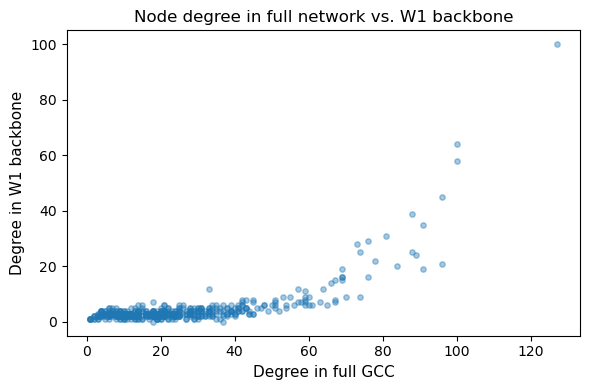

Top 10 artists by degree in the full GCC and their backbone degrees:


,degree_full,degree_backbone
artist,,
Led Zeppelin,127,100
Bob Dylan,100,64
Queen (band),100,58
Metallica,96,21
Deep Purple,96,45
Black Sabbath,91,19
David Bowie,91,35
Alice in Chains,89,24
Jimi Hendrix,88,39


In [12]:
# Degree in the full GCC
deg_full = dict(G_gcc.degree())

# Degree in the backbone B1
deg_backbone = dict(B1.degree())

# Build a DataFrame with one row per node in the GCC
rows = []
for n in G_gcc.nodes():
    rows.append({
        "artist": n,
        "degree_full": deg_full.get(n, 0),
        "degree_backbone": deg_backbone.get(n, 0),
    })

deg_back_df = pd.DataFrame(rows)

# Compute correlations between full and backbone degrees
pearson_deg = deg_back_df["degree_full"].corr(deg_back_df["degree_backbone"], method="pearson")
spearman_deg = deg_back_df["degree_full"].corr(deg_back_df["degree_backbone"], method="spearman")

print(f"Pearson correlation (degree_full vs degree_backbone):  {pearson_deg:.3f}")
print(f"Spearman correlation (degree_full vs degree_backbone): {spearman_deg:.3f}")

# Scatter plot: degree in full network vs degree in backbone
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(
    deg_back_df["degree_full"],
    deg_back_df["degree_backbone"],
    alpha=0.4,
    s=15,
)

ax.set_xlabel("Degree in full GCC", fontsize=11)
ax.set_ylabel("Degree in W1 backbone", fontsize=11)
ax.set_title("Node degree in full network vs. W1 backbone", fontsize=12)
plt.tight_layout()
plt.show()

# Inspect a few top artists in both views
top_artists_compare = (
    deg_back_df
    .sort_values("degree_full", ascending=False)
    .head(10)
    .set_index("artist")[["degree_full", "degree_backbone"]]
)
print("Top 10 artists by degree in the full GCC and their backbone degrees:")
display(top_artists_compare)


The comparison between degrees in the full GCC and in the W1 backbone shows a clear, but not perfect, positive relationship. The Pearson correlation of **0.705** and Spearman correlation of **0.533** indicate that artists who are highly connected in the full network generally retain higher degree after backbone extraction, although ranks are not preserved exactly. The scatter plot illustrates this trend: most points follow an increasing pattern, with a small number of extreme hubs standing out. The table for the top-degree artists makes the effect more concrete. **Led Zeppelin**, **Bob Dylan**, and **Queen (band)** retain very high degrees in the backbone (100, 64, and 58, respectively), which means that most of their connections are considered structurally significant by the disparity filter. In contrast, artists such as **Metallica** and **Black Sabbath** lose a larger fraction of their links (96→21 and 91→19), suggesting that many of their ties are more locally redundant or less critical for global connectivity. Overall, the backbone preserves the central roles of the main hubs while selectively pruning a substantial number of weaker connections around them.


## Overall interpretation of the rock artists network

- The rock artists network appears as a **dense, hub-dominated system** with a clear core–periphery organization. The degree distribution is heavy-tailed: degrees span from 1 to 127 with a median around 20, so most artists have a moderate number of neighbors while a small set of hubs accumulate many links. This implies that connectivity is strongly concentrated around a limited group of key artists. 

- Centrality provides a clearer picture. Classical acts such as **Led Zeppelin**, **Bob Dylan**, **Queen (band)**, and **Deep Purple** rank at the top of both degree and betweenness centrality and occupy the bright, central region of the ForceAtlas2 layout. The degree–betweenness scatter plot shows a strong positive trend, but also some spread at intermediate degrees, indicating different structural roles: some artists act as **brokers** connecting several regions of the graph, while others with similar degree function mainly as **local hubs** inside a single dense community. 

- Assortativity and attribute analyses link structure to external information. Degree assortativity is essentially neutral, suggesting that high- and low-degree artists mix relatively freely rather than forming separated “elite” and “peripheral” layers. In contrast, degree correlates strongly with Wikipedia article length, and the scatter plot shows a clear upward trend. Structurally central artists therefore tend to be more extensively documented, which matches expectations for historically influential bands. 

- The betweenness-based disparity backbone offers a complementary view by focusing on **structurally significant edges**. The disparity filter (Serrano et al., 2009) retains only about 19% of the edges while leaving almost all nodes in a connected giant component. The comparison between degrees in the full network and in the backbone shows substantial, but not perfect, correlation: hubs such as Led Zeppelin, Bob Dylan, and Queen (band) remain highly connected after pruning, whereas other high-degree artists lose a larger fraction of their links. This indicates that the backbone preserves the core structural roles while filtering out many weaker or locally redundant ties. Overall, standard tools reveal a network in which a small, densely interconnected core of iconic artists organizes connectivity across a large and diverse periphery.
